Saving ideal.csv to ideal (2).csv
Saving test.csv to test (2).csv
Saving train.csv to train (2).csv


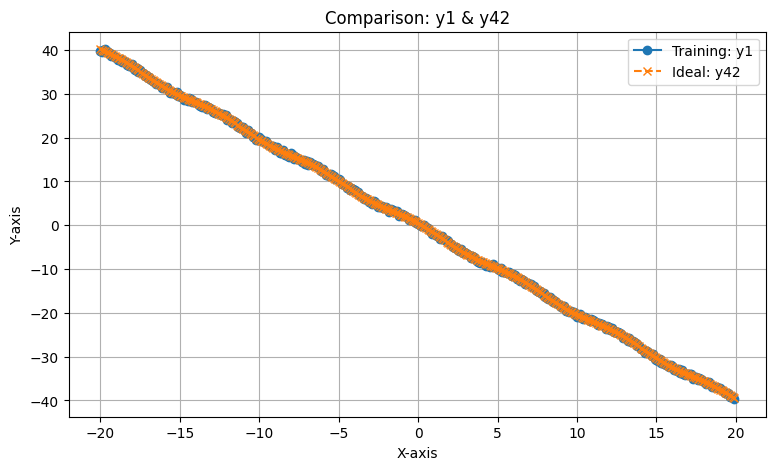

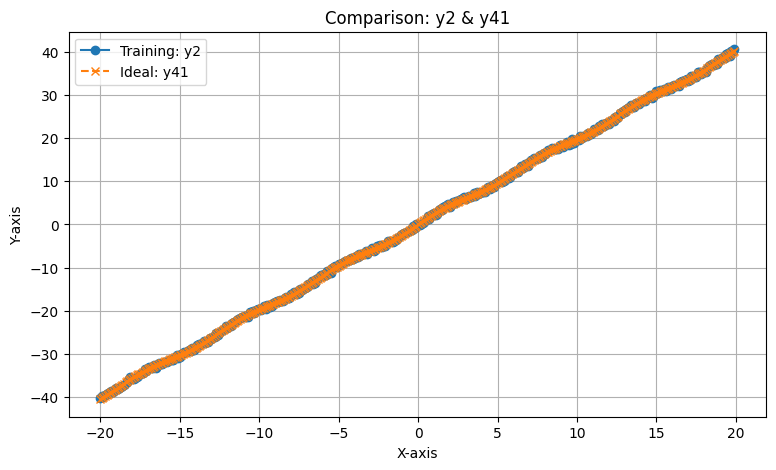

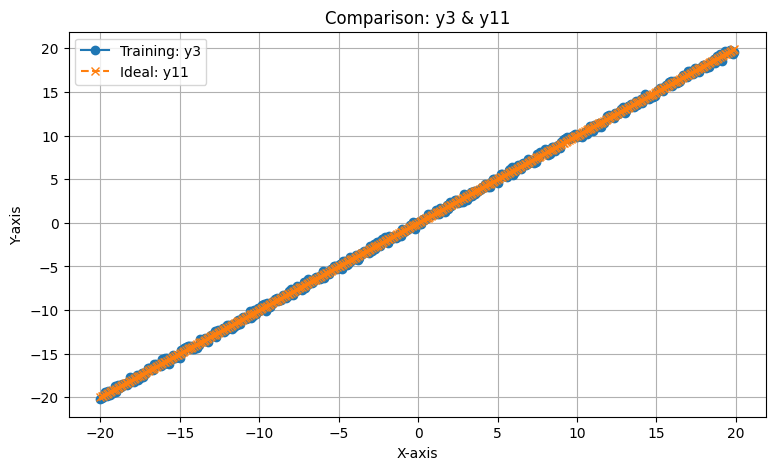

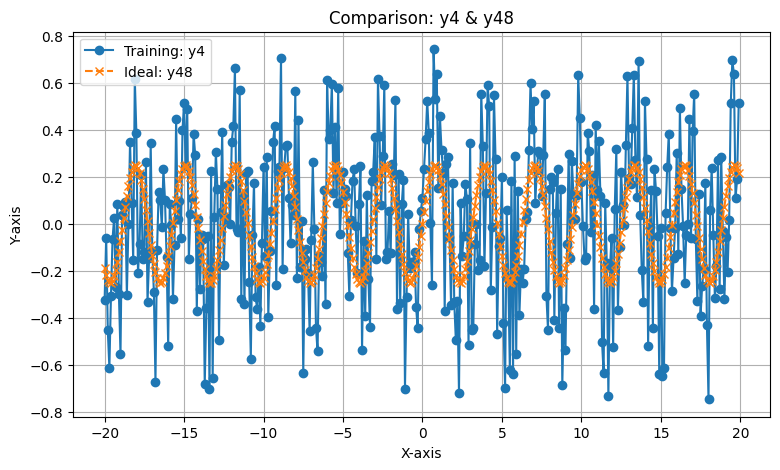

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK



Chosen Ideal Functions:
  y1 --> y42
  y2 --> y41
  y3 --> y11
  y4 --> y48
<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Max Deviations:
  y1: 0.4960
  y2: 0.4977
  y3: 0.4989
  y4: 0.4997


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as db
import unittest
from pathlib import Path
from google.colab import files
uploaded = files.upload()

# === Load Data ===
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
ideal_data = pd.read_csv("ideal.csv")


# === SQLite Storage ===
db_engine = db.create_engine('sqlite:///data_storage.db')
train_data.to_sql('train_set', con=db_engine, if_exists='replace', index=False)
ideal_data.to_sql('ideal_set', con=db_engine, if_exists='replace', index=False)
test_data.to_sql('test_set', con=db_engine, if_exists='replace', index=False)


# === Identify Best Ideal Functions ===
def compute_ssd(target, reference):
    return np.sum(np.square(target - reference))


chosen_functions = {}
ideal_features = [col for col in ideal_data.columns if col != 'x']

for train_feature in ['y1', 'y2', 'y3', 'y4']:
    optimal_match = None
    min_error = float('inf')

    for ideal_feature in ideal_features:
        error = compute_ssd(train_data[train_feature], ideal_data[ideal_feature])
        if error < min_error:
            min_error = error
            optimal_match = ideal_feature

    chosen_functions[train_feature] = optimal_match

# === Compute Maximum Allowed Deviation ===
deviation_limits = {}
for train_feature, ideal_feature in chosen_functions.items():
    deviation_limits[train_feature] = np.max(np.abs(train_data[train_feature] - ideal_data[ideal_feature]))

# === Match Test Data to Best Ideal Function ===
mapped_results = []
for _, row in test_data.iterrows():
    x_val, y_val = row['x'], row['y']
    best_fit = None
    min_deviation = float('inf')

    for train_feature, ideal_feature in chosen_functions.items():
        corresponding_y = ideal_data.loc[ideal_data['x'] == x_val, ideal_feature].values
        if len(corresponding_y) == 0:
            continue

        current_deviation = np.abs(y_val - corresponding_y[0])
        threshold = np.sqrt(2) * deviation_limits[train_feature]

        if current_deviation <= threshold and current_deviation < min_deviation:
            min_deviation = current_deviation
            best_fit = train_feature

    if best_fit:
        mapped_results.append([x_val, y_val, best_fit, min_deviation])

# Store Mappings in Database
mappings_df = pd.DataFrame(mapped_results, columns=['x', 'y', 'matched_function', 'deviation'])
mappings_df.to_sql('mappings', con=db_engine, if_exists='replace', index=False)


# === Visualization ===
def visualize_training_vs_ideal():
    for train_feature, ideal_feature in chosen_functions.items():
        plt.figure(figsize=(9, 5))
        plt.plot(train_data['x'], train_data[train_feature], 'o-', label=f'Training: {train_feature}')
        plt.plot(ideal_data['x'], ideal_data[ideal_feature], 'x--', label=f'Ideal: {ideal_feature}')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title(f'Comparison: {train_feature} & {ideal_feature}')
        plt.legend()
        plt.grid()
        plt.show()


# Unit Test for Least Squares Calculation
class TestLeastSquares(unittest.TestCase):
    def test_ssd_computation(self):
        arr1 = np.array([1, 2, 3])
        arr2 = np.array([1, 2, 3])
        self.assertEqual(compute_ssd(arr1, arr2), 0)

        arr3 = np.array([2, 3, 4])
        self.assertEqual(compute_ssd(arr1, arr3), 3)  # (1-2)^2 + (2-3)^2 + (3-4)^2


# === Execute Functions ===
visualize_training_vs_ideal()
print("\nChosen Ideal Functions:")
for train_feature, ideal_feature in chosen_functions.items():
    print(f"  {train_feature} --> {ideal_feature}")

print(unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestLeastSquares)))

print("\nMax Deviations:")
for train_feature, deviation in deviation_limits.items():
    print(f"  {train_feature}: {deviation:.4f}")
